In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox

ModuleNotFoundError: No module named 'osmnx'

### OSMnx

<AxesSubplot:>

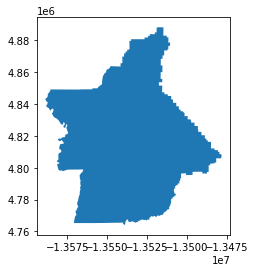

In [2]:
### get Butte county boundary
ca_counties = gpd.read_file('network_inputs/ca-county-boundaries/CA_Counties/CA_Counties_TIGER2016.shp')
butte = ca_counties[ca_counties['NAME']=='Butte']
butte.plot()

In [3]:
### Download and clean data using OSMnx: drive and service
# butte_g = ox.graph_from_polygon(butte.to_crs('epsg:4326')['geometry'].iloc[0], network_type='drive_service')

### Download and clean data using OSMnx: drive only
butte_g = ox.graph_from_polygon(butte.to_crs('epsg:4326')['geometry'].iloc[0], network_type='drive')
# butte_g = ox.utils_graph.get_largest_component(butte_g, strongly=True)

In [6]:
butte_g2 = ox.utils_graph.get_largest_component(butte_g, strongly=True)

In [7]:
butte_g3 = ox.simplification.simplify_graph(butte_g2, strict=True, remove_rings=True)

Exception: This graph has already been simplified, cannot simplify it again.

In [9]:
### Nodes and Edges GDF
### Drive and service: (17220, 6) (41841, 17)
### Drive only: (13746, 6) (33077, 15)
butte_nodes, butte_edges = ox.graph_to_gdfs(butte_g2)
print(butte_nodes.shape, butte_edges.shape)
# butte_nodes.to_csv('network_inputs/butte_nodes_drive.csv', index=False)
# butte_edges.to_csv('network_inputs/butte_edges_drive.csv', index=False)

(13749, 6) (33081, 15)


In [11]:
butte_edges[butte_edges['u']==butte_edges['v']]

,osmid,name,highway,oneway,length,geometry,lanes,ref,maxspeed,bridge,junction,access,u,v,key
1070,10289555,NaN,residential,False,184.478,"LINESTRING (-121.57270 39.78926, -121.57279 39...",NaN,NaN,NaN,NaN,NaN,NaN,86410143,86410143,0
1071,10289555,NaN,residential,False,184.478,"LINESTRING (-121.57270 39.78926, -121.57309 39...",NaN,NaN,NaN,NaN,NaN,NaN,86410143,86410143,1
1453,10297531,Tara Terrace,residential,False,292.930,"LINESTRING (-121.84733 39.76915, -121.84810 39...",NaN,NaN,NaN,NaN,NaN,NaN,86607118,86607118,0
1454,10297531,Tara Terrace,residential,False,292.930,"LINESTRING (-121.84733 39.76915, -121.84721 39...",NaN,NaN,NaN,NaN,NaN,NaN,86607118,86607118,1
1480,10289586,NaN,residential,False,259.719,"LINESTRING (-121.51610 39.40453, -121.51531 39...",NaN,NaN,NaN,NaN,NaN,NaN,86410537,86410537,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30899,10292367,Toyon Hills Drive,residential,False,450.447,"LINESTRING (-121.34654 39.56169, -121.34686 39...",NaN,NaN,NaN,NaN,NaN,NaN,86472892,86472892,1
31333,"[10297873, 10292381, 10298071]","[Pacific Drive, Orchard Drive, Foothill Road]",residential,False,1095.256,"LINESTRING (-121.64414 39.74566, -121.64408 39...",NaN,NaN,NaN,NaN,NaN,NaN,86473219,86473219,0
31334,"[10297873, 10292381, 10298071]","[Pacific Drive, Foothill Road, Orchard Drive]",residential,False,1095.256,"LINESTRING (-121.64414 39.74566, -121.64417 39...",NaN,NaN,NaN,NaN,NaN,NaN,86473219,86473219,1
32985,10289951,NaN,residential,False,70.274,"LINESTRING (-121.49598 39.52316, -121.49587 39...",NaN,NaN,NaN,NaN,NaN,NaN,86409129,86409129,0


In [5]:
### add id to node
butte_nodes = pd.read_csv('network_inputs/butte_nodes_drive.csv')
# butte_nodes = pd.read_csv('network_inputs/butte_ctm_nodes.csv')
butte_nodes['nid'] = np.arange(butte_nodes.shape[0])
butte_nodes['lon'] = butte_nodes['x']
butte_nodes['lat'] = butte_nodes['y']
butte_nodes[['nid', 'osmid', 'lon', 'lat']].to_csv('network_inputs/butte_nodes_sim.csv', index=False)
# butte_nodes[['nid', 'osmid', 'lon', 'lat']].to_csv('network_inputs/butte_ctm_nodes_sim.csv', index=False)
### Further process
butte_edges = pd.read_csv('network_inputs/butte_edges_drive.csv')
# butte_edges = pd.read_csv('network_inputs/butte_ctm_edges_manual.csv')
# butte_edges['geometry'] = butte_edges['WKT']
butte_edges.head()
butte_edges['type'] = butte_edges['highway']
butte_edges['type'] = np.where(butte_edges['highway']=="['residential', 'tertiary']", 'residential', butte_edges['type'])
butte_edges['type'] = np.where(butte_edges['highway']=="['trunk', 'motorway']", 'motorway', butte_edges['type'])
butte_edges['type'] = np.where(butte_edges['highway']=="['tertiary', 'unclassified']", 'unclassified', butte_edges['type'])
butte_edges['type'] = np.where(butte_edges['highway']=="['residential', 'unclassified']", 'unclassified', butte_edges['type'])
# butte_edges['type'].unique()
### max speed
butte_edges['maxmph'] = 25*0.8
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['motorway', 'motorway_link']), 55, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['trunk', 'trunk_link']), 55, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['primary', 'primary_link']), 55, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['secondary', 'secondary_link']), 25, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['tertiary', 'tertiary_link']), 25, butte_edges['maxmph'])
### lanes
butte_edges['lanes'] = 1
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['motorway', 'motorway_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['trunk', 'trunk_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['primary', 'primary_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['secondary', 'secondary_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['tertiary', 'tertiary_link']), 2, butte_edges['lanes'])
### edge_id, start and end node
butte_edges['eid'] = np.arange(butte_edges.shape[0])
butte_edges = butte_edges.merge(butte_nodes[['nid', 'osmid']], how='left', left_on='u', right_on='osmid')
butte_edges = butte_edges.merge(butte_nodes[['nid', 'osmid']], how='left', left_on='v', right_on='osmid', suffixes=['_s', '_e'])
butte_edges[['eid', 'nid_s', 'nid_e', 'type', 'length', 'maxmph', 'lanes', 'geometry']].to_csv('network_inputs/butte_edges_sim.csv', index=False)
# butte_edges[['eid', 'nid_s', 'nid_e', 'length', 'maxmph', 'lanes', 'geometry']].to_csv('network_inputs/butte_ctm_edges_sim.csv', index=False)

### CTM

In [59]:
from shapely.geometry import Point
from collections import Counter

### Load nodes and eges
butte_nodes = pd.read_csv('network_inputs/butte_nodes_drive.csv')
butte_nodes = gpd.GeoDataFrame(butte_nodes, crs='epsg:4326', geometry=[Point(xy) for xy in zip(butte_nodes.x, butte_nodes.y)])
butte_edges = pd.read_csv('network_inputs/butte_edges_drive.csv')

In [75]:
### Read city boundary
ca_cities = gpd.read_file('ca-places-boundaries/CA_Places_TIGER2016.shp')
paradise = ca_cities.loc[ca_cities['NAMELSAD']=='Paradise town', 'geometry'].to_crs('epsg:3857').buffer(300).to_crs('epsg:4326').iloc[0]

spatial_index = butte_nodes.sindex
possible_matches_index = list(spatial_index.intersection(paradise.bounds))
possible_matches = butte_nodes.iloc[possible_matches_index]
paradise_nodes = possible_matches[possible_matches.intersects(paradise)].reset_index(drop=True)
# paradise_nodes.to_csv('network_inputs/paradise_nodes.csv', index=False)
# display(paradise_nodes.head())

regional_route_files = ['skyway_nodes', 'neal_nodes', 'clark_nodes', 'pentz_nodes', 'CA70_nodes', 'CA70_oroville_nodes', 'CA149_nodes']
regional_nodes_list = []
for file in regional_route_files:
    regional_route_nodes = pd.read_csv('network_inputs/{}.csv'.format(file))
    regional_nodes_list.append(regional_route_nodes)
regional_nodes = pd.concat(regional_nodes_list)

potential_ctm_nodes = list(set(
    paradise_nodes['osmid'].values.tolist() + 
    regional_nodes['osmid'].values.tolist()))

### Remove small branch roads
undirected_nodes = pd.DataFrame(np.sort(butte_edges[['u', 'v']].values, axis=1), columns=[['u', 'v']]).drop_duplicates()
node_counts = Counter(undirected_nodes.values.flatten().tolist())
single_count_nodes = [n for n, v in node_counts.items() if v==1]
# print(len(node_counts), len(single_count_nodes))

# ### keep type
ctm_edges = butte_edges.copy().loc[
    ~(butte_edges['highway'].isin(['residential', 'living_street']) & (
        (butte_edges['u'].isin(single_count_nodes)) |
        (butte_edges['v'].isin(single_count_nodes)))
     ) & (
    butte_edges['u'].isin(potential_ctm_nodes)) & (
    butte_edges['v'].isin(potential_ctm_nodes))]
ctm_edges.to_csv('network_inputs/butte_ctm_edges.csv', index=False)
ctm_edges.shape

(2887, 15)

In [45]:
### Assign zones to CTM nodes
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import Point
import reduce_network_util

### extract CTM node from manually selected CTM edges
ctm_edges = pd.read_csv('network_inputs/butte_ctm_edges_manual.csv')
ctm_edges = ctm_edges.rename(columns={'WKT': 'geometry'})
ctm_nodes_list = np.unique(ctm_edges['u'].values.tolist() + ctm_edges['v'].values.tolist())
print(len(ctm_nodes_list), ctm_nodes_list[0:6])

### CTM nodes gdf
nodes = pd.read_csv('network_inputs/butte_nodes_drive.csv')
nodes = gpd.GeoDataFrame(nodes, geometry=[Point(xy) for xy in zip(nodes.x, nodes.y)], crs='epsg:4326').to_crs('epsg:3857')
ctm_nodes = nodes[nodes['osmid'].isin(ctm_nodes_list)].reset_index(drop=True)

### clean the network
nodes_no_stag, edges_no_stag = reduce_network_util.remove_stag_nodes(ctm_nodes, ctm_edges, iteration=20)
nodes_remain, edges_remain = reduce_network_util.remove_false_intersections(nodes_no_stag, edges_no_stag)
nodes_long, edges_long = reduce_network_util.short_elements_to_nodes(nodes_remain, edges_remain)
nodes_no_stag, edges_no_stag = reduce_network_util.remove_stag_nodes(nodes_long, edges_long)
nodes_remain, edges_remain = reduce_network_util.remove_false_intersections(nodes_no_stag, edges_no_stag)

### populate node attributes
nodes = nodes_remain[['x', 'y', 'osmid']].copy()
nodes['type'] = 'real'
nodes['node_id'] = np.arange(nodes.shape[0])
nodes = nodes.rename(columns={'x': 'lon', 'y': 'lat', 'node_id': 'nid'})
display(nodes[['nid', 'lon', 'lat', 'type', 'osmid']].head())
nodes[['nid', 'lon', 'lat', 'type', 'osmid']].to_csv('network_inputs/butte_simplified_ctm_nodes.csv', index=False)

### populate edge attributes
edges = edges_remain[['u', 'v', 'highway', 'geometry']].copy()
edges['link_id'] = np.arange(edges.shape[0])
edges = edges.rename(columns={'link_id': 'eid', 'u': 'start_osmid', 'v': 'end_osmid', 'highway': 'type'})
# edges['start_osmid'] = edges['start_osmid'].astype('str')
edges = edges.merge(nodes[['osmid', 'nid']], how='left', left_on='start_osmid', right_on='osmid').merge(nodes[['osmid', 'nid']], how='left', left_on='end_osmid', right_on='osmid', suffixes=['_s', '_e'])
print(edges['type'].unique())

# ### max speed
edges['maxmph'] = 25*0.8
edges['maxmph'] = np.where(edges['type'].isin(['motorway', 'motorway_link']), 55, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['trunk', 'trunk_link']), 55, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['primary', 'primary_link']), 55, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['secondary', 'secondary_link']), 25, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['tertiary', 'tertiary_link']), 25, edges['maxmph'])

# ### lanes
edges['lanes'] = 1
edges['lanes'] = np.where(edges['type'].isin(['motorway', 'motorway_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['trunk', 'trunk_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['primary', 'primary_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['secondary', 'secondary_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['tertiary', 'tertiary_link']), 2, edges['lanes'])

# ### capacity
edges['capacity'] = edges['lanes']*1900
### fft
edges = gpd.GeoDataFrame(edges, crs='epsg:4326', geometry=edges['geometry'].apply(loads))
edges['length'] = edges['geometry'].to_crs('epsg:3857').length
edges['fft'] = edges['length']/edges['maxmph'] * 2.23694

edges = edges[['eid', 'nid_s', 'nid_e', 'type', 'length', 'maxmph', 'lanes', 'capacity', 'fft', 'start_osmid', 'end_osmid', 'geometry']]
display(edges.head())
edges.to_csv('network_inputs/butte_simplified_ctm_edges.csv', index=False)

## read evacuation zone file
evac_zones = gpd.read_file('demand_inputs/digitized_evacuation_zone/digitized_evacuation_zone.shp').to_crs('epsg:3857')
nodes = gpd.GeoDataFrame(nodes, geometry=[Point(xy) for xy in zip(nodes.lon, nodes.lat)], crs='epsg:4326').to_crs('epsg:3857')
nodes_sindex = nodes.sindex
nodes['evac_zone'] = -1

for zone in evac_zones.itertuples():
    zone_id = getattr(zone, 'id')
    zone_geom = getattr(zone, 'geometry').buffer(10) ### a small buffer to cover nodes in the gap of zones
    coarse_node_ids = list(nodes_sindex.intersection(zone_geom.bounds))
    coarse_nodes = nodes.iloc[coarse_node_ids]
    precise_nodes = coarse_nodes[coarse_nodes.intersects(zone_geom)]
    nodes['evac_zone'] = np.where(nodes['osmid'].isin(
        precise_nodes['osmid']), zone_id, nodes['evac_zone'])

nodes.groupby('evac_zone').size().head()
nodes.to_crs('epsg:4326').to_csv('network_inputs/butte_simplified_ctm_nodes_zones.csv', index=False)

843 [86370139 86370172 86370395 86371548 86371598 86373016]
remove_loops() removes 0 edges
remove_multiedges() removes 0 edges
iteration  0
  # staggring nodes:  11
iteration  1
  # staggring nodes:  9
iteration  2
  # staggring nodes:  9
iteration  3
  # staggring nodes:  7
iteration  4
  # staggring nodes:  5
iteration  5
  # staggring nodes:  5
iteration  6
  # staggring nodes:  4
iteration  7
  # staggring nodes:  4
iteration  8
  # staggring nodes:  3
iteration  9
  # staggring nodes:  1
iteration  10
  # staggring nodes:  1
iteration  11
  # staggring nodes:  1
iteration  12
  # staggring nodes:  1
iteration  13
  # staggring nodes:  1
iteration  14
  # staggring nodes:  1
iteration  15
  # staggring nodes:  1
iteration  16
  # staggring nodes:  1
iteration  17
  # staggring nodes:  0
iteration  18
  # staggring nodes:  0
iteration  19
  # staggring nodes:  0
remove_loops() removes 0 edges
remove_multiedges() removes 0 edges
  # staggring nodes: 0, # non-intersection nodes 652
# 

,nid,lon,lat,type,osmid
16,0,-121.589019,39.755914,real,86606471
17,1,-121.581956,39.777753,real,86508207
20,2,-121.600692,39.755920,real,86606520
22,3,-121.586547,39.777728,real,86508220
30,4,-121.600650,39.777651,real,86508288


[motorway, motorway_link, trunk, trunk_link, primary, secondary, tertiary, residential]
Categories (8, object): [motorway, motorway_link, trunk, trunk_link, primary, secondary, tertiary, residential]


,eid,nid_s,nid_e,type,length,maxmph,lanes,capacity,fft,start_osmid,end_osmid,geometry
0,0,96,33,motorway,4223.551071,55.0,2,3800,171.778733,476139708_m,449397448,"LINESTRING (-121.66227 39.60135, -121.66067 39..."
1,1,16,96,motorway,4173.838601,55.0,2,3800,169.756846,86419072,476139708_m,"LINESTRING (-121.63011 39.58652, -121.63129 39..."
2,2,14,15,motorway,395.198724,55.0,2,3800,16.073379,476161268,476161271,"LINESTRING (-121.62049 39.59374, -121.62041 39..."
3,3,29,14,motorway,731.976221,55.0,2,3800,29.770671,476164501,476161268,"LINESTRING (-121.61961 39.58872, -121.61985 39..."
4,4,33,29,motorway_link,2000.966666,55.0,2,3800,81.382589,449397448,476164501,"LINESTRING (-121.62990 39.58611, -121.62783 39..."


/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
### Assign speed etc to CTM edges

### Demand

In [2]:
import random 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist 

from shapely import wkt 
from shapely.geometry import Point

In [3]:
### node file
# nodes_df = pd.read_csv('network_inputs/butte_simplified_ctm_nodes.csv')
nodes_df = pd.read_csv('network_inputs/butte_nodes_sim.csv')
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=[Point(xy) for xy in zip(nodes_df.lon, nodes_df.lat)], crs='epsg:4326').to_crs('epsg:3857')

### city boundary
cities = gpd.read_file('network_inputs/ca-places-boundaries/CA_Places_TIGER2016.shp').to_crs('epsg:3857')
### individual cities
paradise = cities[cities['NAMELSAD']=='Paradise town'].copy()
magalia = cities[cities['NAMELSAD']=='Magalia CDP'].copy()
chico = cities[cities['NAMELSAD']=='Chico city'].copy()
oroville = cities.loc[cities['NAME'].isin(['Palermo', 'Oroville East', 'South Oroville', 'Kelly Ridge', 'Oroville', 'Thermalito'])].copy()

### parcel file
parcels = gpd.read_file('demand_inputs/BCAG_GIS_Request/parcel/parcel.shp').to_crs('epsg:3857')

### evacuation zone
evac_zones = gpd.read_file('demand_inputs/digitized_evacuation_zone/digitized_evacuation_zone.shp').to_crs('epsg:3857')
evac_zones_test = evac_zones.loc[evac_zones['id']<=14].copy()
evac_zones_test.to_crs('epsg:3857')['geometry'].unary_union.area/1e6

90.89957966542207

In [20]:
### Residential parcels in Paradise
### did not consider Magalia and needs to be changed in the future
### did not consider all land use types

### While the pre-fire population of Paradise was an estimated 26,800, according to the U.S. 2010 Census, a door-to-door survey conducted in April of this year revealed only 2,034 residents remain
### https://sf.curbed.com/2019/7/12/20692079/town-destroyed-by-pg-e-fire-loses-92-percent-of-its-population
paradise_parcels = parcels.loc[(parcels['JURISDICTI']=='Paradise') & (parcels['LANDUSE'].isin(['RZ', 'RV', 'RS']))].copy().reset_index(drop=True)
magalia_parcels = parcels.loc[~parcels['CityStZIP'].isnull()].copy().reset_index(drop=True)
magalia_parcels = magalia_parcels.loc[(magalia_parcels['CityStZIP'].apply(lambda x: x[0:7])=='MAGALIA') & (magalia_parcels['LANDUSE'].isin(['RZ', 'RV', 'RS']))].copy().reset_index(drop=True)
paradise_magalia_parcels = pd.concat([paradise_parcels, magalia_parcels])
paradise_magalia_parcels.groupby('LANDUSE').size()

LANDUSE
RS    4349
RV     837
RZ    7138
dtype: int64

In [21]:
### CTM
### Give an evacuation zone to each household
paradise_magalia_parcels['centroid'] = paradise_magalia_parcels.apply(lambda x: x['geometry'].centroid, axis=1)
paradise_magalia_parcels = paradise_magalia_parcels.set_geometry('centroid')
paradise_magalia_parcels_sindex = paradise_magalia_parcels.sindex
paradise_magalia_parcels['evac_zone'] = -1

for zone in evac_zones.itertuples():
    zone_id = getattr(zone, 'id')
    zone_geom = getattr(zone, 'geometry').buffer(10) ### a small buffer to cover nodes at the boundaries
    coarse_parcel_ids = list(paradise_magalia_parcels_sindex.intersection(zone_geom.bounds))
    coarse_parcels = paradise_magalia_parcels.iloc[coarse_parcel_ids]
    precise_parcels = coarse_parcels[coarse_parcels.intersects(zone_geom)]
    paradise_magalia_parcels['evac_zone'] = np.where(paradise_magalia_parcels['APN'].isin(
        precise_parcels['APN']), zone_id, paradise_magalia_parcels['evac_zone'])
paradise_magalia_parcels.to_crs('epsg:4326').to_csv('demand_inputs/paradise_magalia_parcels_labeled.csv', index=False)
display(paradise_magalia_parcels.groupby('evac_zone').size().to_frame('hh_cnts').head())

### Map residential parcels in Paradise to nodes
paradise_magalia_parcels['c_x'] = paradise_magalia_parcels['centroid'].x
paradise_magalia_parcels['c_y'] = paradise_magalia_parcels['centroid'].y
nodes_xy = np.array([nodes_gdf['geometry'].x.values, nodes_gdf['geometry'].y.values]).transpose()
nodes_osmid = nodes_gdf['osmid'].values

def get_closest_node(parcel_x, parcel_y):
    return nodes_osmid[cdist([(parcel_x, parcel_y)], nodes_xy, 'euclidean').argmin()]

paradise_magalia_parcels['closest_node'] = paradise_magalia_parcels.apply(lambda x: get_closest_node(x['c_x'], x['c_y']), axis=1)
display(paradise_magalia_parcels[['APN', 'evac_zone', 'closest_node']].head())



,hh_cnts
evac_zone,
-1,2103
1,1082
2,1014
3,886
4,1211


,APN,evac_zone,closest_node
0,050-011-012-000,1,86406781
1,050-011-013-000,1,86406781
2,050-011-022-000,1,86432131
3,050-011-024-000,1,86432131
4,050-011-025-000,1,86518494


In [72]:
### CTM
### assume 100% of evacuee
evac_pct = 1
### assume 2 veh per household
vphh = 2

### make OD
od_list = []
for parcel in paradise_parcels[['APN', 'evac_zone', 'closest_node']].copy().sample(frac=evac_pct).itertuples():
    for v_id in range(vphh):
        od_list.append([getattr(parcel, 'APN'), v_id, getattr(parcel, 'evac_zone'), getattr(parcel, 'closest_node')])
od = pd.DataFrame(od_list, columns=['APN', 'v_id', 'evac_zone', 'origin_osmid'])
### only look at the first 14 zones
od = od.loc[(od['evac_zone']>0) & (od['evac_zone']<=14)]
od_hh = od.drop_duplicates(subset=['APN']).copy().drop(columns=['v_id', 'origin_osmid']).sample(frac=1)

### making virtual end nodes for CTM for CTM when no nodes are in Chico or Oroville boundary
safe_nodes = {'chico': ['86430818_m', '86462812_m'],
             'oroville': ['86419072', '449397448', '1953726511_m']}

nodes_vdf = nodes_df.copy()
edges_vdf = pd.read_csv('network_inputs/butte_simplified_ctm_edges.csv')
print(nodes_vdf.shape, edges_vdf.shape)

nodes_vdf_list = []
node_vnid = np.max(nodes_vdf['nid'])
edges_vdf_list = []
edge_veid = np.max(edges_vdf['eid'])
for nm in ['chico', 'oroville']:
    before_virtual_nodes = nodes_gdf[nodes_gdf['osmid'].isin(safe_nodes[nm])].copy()
    print(nm, before_virtual_nodes.shape)
    virtual_nodes_lon = np.mean(before_virtual_nodes['lon'])
    virtual_nodes_lat = np.mean(before_virtual_nodes['lat'])
    node_vnid += 1
    nodes_vdf_list.append([node_vnid, 'vsink_{}'.format(nm), 
                           virtual_nodes_lon, virtual_nodes_lat, 
                           'POINT ({} {})'.format(virtual_nodes_lon, virtual_nodes_lat)
                          ])
    for bvn in before_virtual_nodes.to_crs('epsg:4326').itertuples():
        edge_veid += 1
        edges_vdf_list.append([edge_veid, getattr(bvn, 'nid'), node_vnid, 10000, 10000, 100, 
                              'LINESTRING({} {}, {} {})'.format(
                                  getattr(bvn, 'geometry').coords[-1][0], 
                                  getattr(bvn, 'geometry').coords[-1][1], 
                                  virtual_nodes_lon, virtual_nodes_lat)
                              ])

nodes_vdf = pd.concat([nodes_vdf, pd.DataFrame(
    nodes_vdf_list, columns=['nid', 'osmid', 'lon', 'lat', 'geometry'])])
edges_vdf = pd.concat([edges_vdf, pd.DataFrame(
    edges_vdf_list, columns=['eid', 'nid_s', 'nid_e', 'length', 'maxmph', 'lanes', 'geometry'])])
print(nodes_vdf.shape, edges_vdf.shape)
nodes_vdf.to_csv('network_inputs/butte_ctm_nodes_sim_virtual.csv')
edges_vdf.to_csv('network_inputs/butte_ctm_edges_sim_virtual.csv')

### add destination
chico_ratio = 0.7

# d_list = random.choices(
#     safe_nodes['chico'], k=int(od_hh.shape[0]*chico_ratio)) + random.choices(
#     safe_nodes['oroville'], k=od_hh.shape[0]-int(od_hh.shape[0]*chico_ratio))
d_list = random.choices(['vsink_chico', 'vsink_oroville'], k=od_hh.shape[0], weights=[chico_ratio, 1-chico_ratio])

od_hh['destin_osmid'] = d_list
### add departure time
od_hh['dept_time_scen_1'] = 0
od_hh['dept_time_scen_2'] = np.where(
        od_hh['evac_zone'].isin([1,2,3]), 0, np.where(
            od_hh['evac_zone'].isin([4,5,6,7,8]), 157*60, np.where(
                od_hh['evac_zone'].isin([9,10,11,12,13,14]), (157+205)*60, 0)))
od_hh['dept_time_scen_3'] = random.choices(
    range(20*60, 1*3600), k=int(od_hh.shape[0]*0.05)) + random.choices(
    range(1*3600, 2*3600), k=int(od_hh.shape[0]*0.55)) + random.choices(
    range(2*3600, 3*3600), k=int(od_hh.shape[0]*0.35)) + random.choices(
    range(3*3600, 6*3600), k=od_hh.shape[0]-int(od_hh.shape[0]*0.05)-int(od_hh.shape[0]*0.55)-int(od_hh.shape[0]*0.35))
od = od.merge(od_hh[['APN', 'destin_osmid', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']], how='left', on='APN')
print(od.shape)
display(od.head())

# od[['origin_osmid', 'destin_osmid', 'evac_zone', 'hh_id', 'v_id', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']].to_csv('demand_inputs/od.csv', index=False)
od[['APN', 'origin_osmid', 'destin_osmid', 'evac_zone', 'v_id', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']].to_csv('demand_inputs/ctm_od_virtual.csv', index=False)

(108, 6) (310, 12)
chico (2, 6)
oroville (3, 6)
(110, 6) (315, 12)
(20142, 8)


,APN,v_id,evac_zone,origin_osmid,destin_osmid,dept_time_scen_1,dept_time_scen_2,dept_time_scen_3
0,053-161-066-000,0,6,86532495,vsink_chico,0,9420,5500
1,053-161-066-000,1,6,86532495,vsink_chico,0,9420,5500
2,055-190-055-000,0,12,86454823,vsink_chico,0,21720,9514
3,055-190-055-000,1,12,86454823,vsink_chico,0,21720,9514
4,055-130-064-000,0,11,86454823,vsink_oroville,0,21720,5661


In [30]:
# ### Map residential parcels in Paradise to nodes
# paradise_parcels['centroid'] = paradise_parcels.apply(lambda x: x['geometry'].centroid, axis=1)
# paradise_parcels = paradise_parcels.set_geometry('centroid')
# paradise_parcels['c_x'] = paradise_parcels['centroid'].x
# paradise_parcels['c_y'] = paradise_parcels['centroid'].y
# nodes_xy = np.array([nodes_gdf['geometry'].x.values, nodes_gdf['geometry'].y.values]).transpose()
# nodes_osmid = nodes_gdf['osmid'].values

# def get_closest_node(parcel_x, parcel_y):
#     return nodes_osmid[cdist([(parcel_x, parcel_y)], nodes_xy, 'euclidean').argmin()]

# paradise_parcels['closest_node'] = paradise_parcels.apply(lambda x: get_closest_node(x['c_x'], x['c_y']), axis=1)

nodes_evac_origins = paradise_magalia_parcels.groupby('closest_node').size().reset_index().rename(columns={'closest_node': 'osmid', 0: 'hh_cnts'})
print(nodes_evac_origins.shape)
# nodes_evac_origins.head()
display(nodes_evac_origins[nodes_evac_origins['osmid']==86532858])

(2335, 2)


,osmid,hh_cnts
1622,86532858,2


In [23]:
### assign an evacuation zone to each evacuation origin
nodes_evac_origins_gdf = nodes_gdf.merge(nodes_evac_origins, how='right', on='osmid')
nodes_evac_origins_sindex = nodes_evac_origins_gdf.sindex
nodes_evac_origins_gdf['evac_zone'] = -1

for zone in evac_zones.itertuples():
    zone_id = getattr(zone, 'id')
    zone_geom = getattr(zone, 'geometry').buffer(10) ### a small buffer to cover nodes at the boundaries
    coarse_node_ids = list(nodes_evac_origins_sindex.intersection(zone_geom.bounds))
    coarse_nodes = nodes_evac_origins_gdf.iloc[coarse_node_ids]
    precise_nodes = coarse_nodes[coarse_nodes.intersects(zone_geom)]
    nodes_evac_origins_gdf['evac_zone'] = np.where(nodes_evac_origins_gdf['osmid'].isin(
        precise_nodes['osmid']), zone_id, nodes_evac_origins_gdf['evac_zone'])
# nodes_evac_origins_gdf.to_csv('network_inputs/butte_simplified_ctm_nodes_labeled.csv', index=False)
nodes_evac_origins_gdf.groupby('evac_zone').agg({'hh_cnts': np.sum})

,hh_cnts
evac_zone,
-1,2096
1,1029
2,1002
3,918
4,1235
5,654
6,723
7,1063
8,428


In [31]:
### assume 100% of evacuee
evac_pct = 1
### assume 2 veh per household
vphh = 2

### make OD
od_list = []
for node in nodes_evac_origins_gdf[['osmid', 'hh_cnts', 'evac_zone']].copy().sample(frac=evac_pct).itertuples():
    for hh_id in range(getattr(node, 'hh_cnts')):
        for v_id in range(vphh):
            od_list.append([getattr(node, 'osmid'), getattr(node, 'evac_zone'), hh_id, v_id])
od = pd.DataFrame(od_list, columns=['origin_osmid', 'evac_zone', 'hh_id', 'v_id'])
### only look at the first 14 zones
# od = od.loc[od['evac_zone']<=14]
od_hh = od.drop_duplicates(subset=['origin_osmid', 'evac_zone', 'hh_id']).copy().drop(columns='v_id').sample(frac=1)

### find osmids in Oroville or Chico
print(oroville['NAME'].values.tolist()) ### Should be 6
safe_area_dict = {'chico': chico.unary_union, 'oroville': oroville.unary_union}
safe_nodes = dict()
nodes_sindex = nodes_gdf.sindex
for nm, geom in safe_area_dict.items():
    coarse_node_ids = list(nodes_sindex.intersection(geom.bounds))
    coarse_nodes = nodes_gdf.iloc[coarse_node_ids]
    precise_nodes = coarse_nodes[coarse_nodes.intersects(geom)]
    safe_nodes[nm] = precise_nodes['osmid'].values.tolist()
    print(nm, len(precise_nodes))
### for CTM when no nodes are in Chico or Oroville boundary
# safe_nodes = {'chico': ['86430818_m', '86462812_m'],
#              'oroville': ['86419072', '449397448', '1953726511_m']}
    
### virtual end nodes for CTM
# nodes_vdf = nodes_df.copy()
# edges_vdf = pd.read_csv('network_inputs/butte_simplified_ctm_edges.csv')
# print(nodes_vdf.shape, edges_vdf.shape)

# nodes_vdf_list = []
# node_vnid = np.max(nodes_vdf['nid'])
# edges_vdf_list = []
# edge_veid = np.max(edges_vdf['eid'])
# for nm in ['chico', 'oroville']:
#     before_virtual_nodes = nodes_gdf[nodes_gdf['osmid'].isin(safe_nodes[nm])].copy()
#     print(nm, before_virtual_nodes.shape)
#     virtual_nodes_lon = np.mean(before_virtual_nodes['lon'])
#     virtual_nodes_lat = np.mean(before_virtual_nodes['lat'])
#     node_vnid += 1
#     nodes_vdf_list.append([node_vnid, 'vsink_{}'.format(nm), 
#                            virtual_nodes_lon, virtual_nodes_lat, 
#                            'POINT ({} {})'.format(virtual_nodes_lon, virtual_nodes_lat)
#                           ])
#     for bvn in before_virtual_nodes.to_crs('epsg:4326').itertuples():
#         edge_veid += 1
#         edges_vdf_list.append([edge_veid, getattr(bvn, 'nid'), node_vnid, 10000, 10000, 100, 
#                               'LINESTRING({} {}, {} {})'.format(
#                                   getattr(bvn, 'geometry').coords[-1][0], 
#                                   getattr(bvn, 'geometry').coords[-1][1], 
#                                   virtual_nodes_lon, virtual_nodes_lat)
#                               ])

# nodes_vdf = pd.concat([nodes_vdf, pd.DataFrame(
#     nodes_vdf_list, columns=['nid', 'osmid', 'lon', 'lat', 'geometry'])])
# edges_vdf = pd.concat([edges_vdf, pd.DataFrame(
#     edges_vdf_list, columns=['eid', 'nid_s', 'nid_e', 'length', 'maxmph', 'lanes', 'geometry'])])
# print(nodes_vdf.shape, edges_vdf.shape)
# nodes_vdf.to_csv('network_inputs/butte_ctm_nodes_sim_virtual.csv')
# edges_vdf.to_csv('network_inputs/butte_ctm_edges_sim_virtual.csv')

### add destination
chico_ratio = 0.7

d_list = random.choices(
    safe_nodes['chico'], k=int(od_hh.shape[0]*chico_ratio)) + random.choices(
    safe_nodes['oroville'], k=od_hh.shape[0]-int(od_hh.shape[0]*chico_ratio))
# d_list = random.choices(['vsink_chico', 'vsink_oroville'], k=od_hh.shape[0], weights=[chico_ratio, 1-chico_ratio])

od_hh['destin_osmid'] = d_list
### add departure time
od_hh['dept_time_scen_1'] = 0
od_hh['dept_time_scen_2'] = np.where(
        od_hh['evac_zone'].isin([1,2,3]), 0, np.where(
            od_hh['evac_zone'].isin([4,5,6,7,8]), 157*60, np.where(
                od_hh['evac_zone'].isin([9,10,11,12,13,14]), (157+205)*60, 0)))
od_hh['dept_time_scen_3'] = random.choices(
    range(20*60, 1*3600), k=int(od_hh.shape[0]*0.05)) + random.choices(
    range(1*3600, 2*3600), k=int(od_hh.shape[0]*0.55)) + random.choices(
    range(2*3600, 3*3600), k=int(od_hh.shape[0]*0.35)) + random.choices(
    range(3*3600, 6*3600), k=od_hh.shape[0]-int(od_hh.shape[0]*0.05)-int(od_hh.shape[0]*0.55)-int(od_hh.shape[0]*0.35))
od = od.merge(od_hh, how='left', on=['origin_osmid', 'evac_zone', 'hh_id'])
print(od.shape)
print(np.unique(od['evac_zone']))
display(od.head())
display(od[od['origin_osmid']==86532858])

# od[['origin_osmid', 'destin_osmid', 'evac_zone', 'hh_id', 'v_id', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']].to_csv('demand_inputs/od.csv', index=False)
od[['origin_osmid', 'destin_osmid', 'evac_zone', 'hh_id', 'v_id', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']].to_csv('demand_inputs/paradise_magalia_od_virtual.csv', index=False)

['Oroville', 'Kelly Ridge', 'Oroville East', 'Palermo', 'South Oroville', 'Thermalito']
chico 3218
oroville 2640
(24648, 8)
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19]


,origin_osmid,evac_zone,hh_id,v_id,destin_osmid,dept_time_scen_1,dept_time_scen_2,dept_time_scen_3
0,86481961,3,0,0,86449664,0,0,1575
1,86481961,3,0,1,86449664,0,0,1575
2,86481961,3,1,0,86440793,0,0,3674
3,86481961,3,1,1,86440793,0,0,3674
4,86481961,3,2,0,86464898,0,0,8506


,origin_osmid,evac_zone,hh_id,v_id,destin_osmid,dept_time_scen_1,dept_time_scen_2,dept_time_scen_3
17014,86532858,-1,0,0,765575895,0,0,7955
17015,86532858,-1,0,1,765575895,0,0,7955
17016,86532858,-1,1,0,86457376,0,0,5387
17017,86532858,-1,1,1,86457376,0,0,5387


### Closure locations

In [1]:
### based on https://matthewkudija.com/blog/2018/11/19/google-maps-api/
import requests

def get_lat_lng(apiKey, address):
    """
    Returns the latitude and longitude of a location using the Google Maps Geocoding API. 
    API: https://developers.google.com/maps/documentation/geocoding/start

    # INPUT -------------------------------------------------------------------
    apiKey                  [str]
    address                 [str]

    # RETURN ------------------------------------------------------------------
    lat                     [float] 
    lng                     [float] 
    """
    import requests
    url = ('https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'
           .format(address.replace(' ','+'), apiKey))
    try:
        response = requests.get(url)
        resp_json_payload = response.json()
        lat = resp_json_payload['results'][0]['geometry']['location']['lat']
        lng = resp_json_payload['results'][0]['geometry']['location']['lng']
    except:
        print('ERROR: {}'.format(address))
        lat = 0
        lng = 0
    return lat, lng

In [11]:
# get key
fname = 'google_api.key'
file  = open(fname, 'r')
apiKey = file.read()

# location file
fire_locations = pd.read_csv('demand_inputs/fire_locations/fire_locations.csv')
fire_locations.head()
id_lat_lon_list = []
for row in fire_locations.itertuples():
    lat, lon = get_lat_lng(apiKey, getattr(row, 'Location')+' , CA')
    id_lat_lon_list.append([getattr(row, 'ID'), lat, lon])
id_lat_lon_df = pd.DataFrame(id_lat_lon_list, columns=['ID', 'lat', 'lon'])
fire_locations = pd.merge(fire_locations, id_lat_lon_df, how='left', on='ID')
fire_locations.head()

# save file
fire_locations.to_csv('demand_inputs/fire_locations/fire_locations_coord.csv')

,ID,Name,Injury_Death,Location,Time,lat,lon
0,1,Joyce Acheson,Death,"1250 Elliot Road, Paradise",NaN,39.758205,-121.599917
1,2,Herbert alderman,Death,"5775 Deanna Way, Paradise",NaN,39.756489,-121.592270
2,3,Teresa Ammons,Death,"6674 Pentz Road, Paradise",NaN,39.778586,-121.576086
3,4,Rafaela Andrade,Death,"6664 Moore Road, Paradise",NaN,39.786365,-121.588349
4,5,Carol Arrington,Death,"1866 Stark Lane, Paradise",NaN,39.773183,-121.573012


In [16]:
simulation_fire_locations = fire_locations.copy()
simulation_fire_locations = simulation_fire_locations[['lat', 'lon']]
simulation_fire_locations['speed'] = 0
simulation_fire_locations['initial_dist'] = 100
simulation_fire_locations['type'] = 'ember'
simulation_fire_locations['start_time'] = None
simulation_fire_locations['end_time'] = None

spread_fire_locations = pd.DataFrame([[-121.571127, 39.803276, 'initial', 0, 3600*10, 4, 0], ### initial location
                                     [-121.572164, 39.746965, 'pentz', 0, 3600*10, 0, 100], ### Pentz
                                     [-121.607208, 39.744956, 'clark', 3600, 3600*10, 0, 100], ### Clark
                                     [-121.641228, 39.742691, 'neal', 3600*3, 3600*10, 0, 100]],
                                    columns=['lon', 'lat', 'type', 'start_time', 'end_time', 'speed', 'initial_dist']) ### Neal
simulation_fire_locations = pd.concat([simulation_fire_locations, spread_fire_locations])
simulation_fire_locations.to_csv('demand_inputs/fire_locations/simulation_fire_locations.csv', index=False)
simulation_fire_locations.tail(10)

,lat,lon,speed,initial_dist,type,start_time,end_time
78,39.756908,-121.591291,0,100,ember,None,None
79,39.762772,-121.591703,0,100,ember,None,None
80,39.789130,-121.506957,0,100,ember,None,None
81,39.760573,-121.597443,0,100,ember,None,None
82,44.972084,-93.262234,0,100,ember,None,None
83,39.677018,-121.627083,0,100,ember,None,None
0,39.803276,-121.571127,4,0,initial,0,36000
1,39.746965,-121.572164,0,100,pentz,0,36000
2,39.744956,-121.607208,0,100,clark,3600,36000
3,39.742691,-121.641228,0,100,neal,10800,36000
